In [1]:
# pip install opencv-python
# pip install matplotlib
import matplotlib.pyplot as plt
import pathlib
import cv2
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

## Preparing data

In [ ]:
# Directory for the images
!mkdir Dataset
# Directory for the model
!mkdir Model_Glaucoma_detection

In [ ]:
# Unzip dataset
!unzip "/content/all_data.zip" -d "/content/Dataset/"

In [ ]:
# Directory of all images (Non_D and Sus_G)
data_dir='/content/Dataset/all_data'
data_dir = pathlib.Path(data_dir)
print(data_dir)

/content/Dataset/dataset3


In [ ]:
# One example of the Non_D class
Non_D = list(data_dir.glob('Non_D/*'))
print(Non_D[0])
PIL.Image.open(str(Non_D[0]))

In [ ]:
# Image size and batch size
img_height,img_width=227,227
batch_size=8
# Training images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
# Validation images
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
# Classes
class_names = train_ds.class_names
print(class_names)

['Non_D', 'Sus_G']


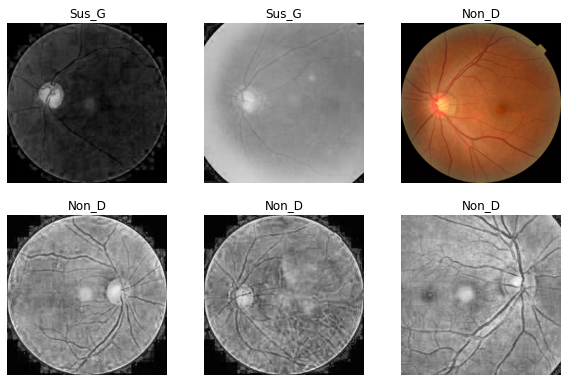

In [ ]:
# Some images from the training folder
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Training The Model


In [ ]:
# Create the model
resnet_model = Sequential()
# Download the pre-trained ResNet50V2 model from keras and save it to ~/.keras/models/ directory (https://keras.io/api/applications/)
pretrained_model=tf.keras.applications.ResNet50V2(include_top=False,
                  input_shape=(227,227,3),
                  pooling='avg',classes=2,
                  weights="imagenet")
# Freeze the layers
for layer in pretrained_model.layers:
        layer.trainable=False
# Training in the upper layers
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.summary()

In [ ]:
# Save the model weights
resnet_model.load_weights(filepath='/content/Model_Glaucoma_detection/ResNetv2model_glaucoma')

In [ ]:
# Compile model
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
# Tensorboard
TensorboardModelo=TensorBoard(log_dir='logs/modelo')

In [ ]:
# Training
epochs=100
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[TensorboardModelo])

Layer ModuleWrapper was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/100
833/833 [==============================] - 49s 42ms/step - loss: 7.5613 - accuracy: 0.8630 - val_loss: 1.2069 - val_accuracy: 0.9520
Epoch 2/100
833/833 [==============================] - 33s 40ms/step - loss: 1.1936 - accuracy: 0.9143 - val_loss: 0.9428 - val_accuracy: 0.8805
Epoch 3/100
833/833 [==============================] - 34s 40ms/step - loss: 0.6211 - accuracy: 0.9229 - val_loss: 0.4660 - val_accuracy: 0.8835
Epoch 4/100
833/833 [==============================] - 34s 41ms/step - loss: 0.2103 - accuracy: 0.9416 - val_loss: 0.1271 - val_accuracy: 0.9580
Epoch 5/100
833/833 [==============================] - 34s 41ms/step - loss: 0.1045 - accuracy: 0.9629 - val_loss: 0.0642 - val_accuracy: 0.9748
Epoch 6/100
833/833 [==============================] - 38s 46ms/step - loss: 0.1114 - accuracy: 0.9566 - val_loss: 0.1350 - val_accuracy: 0.9447
Epoch 7/100
833/833 [==============================] - 34s 41ms/step - loss: 0.1380 - accuracy: 0.9467 - val_loss: 0.0774 - val_ac

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

In [ ]:
# Save the model weights
resnet_model.save_weights(filepath='/content/Model_Glaucoma_detection/ResNetv2model_glaucoma', save_format='tf')

# Evaluating the model

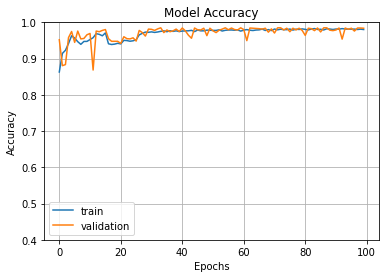

In [ ]:
# Plot model accuracy
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

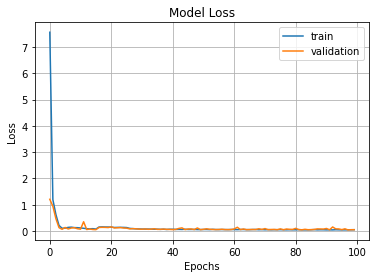

In [ ]:
# Plot model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#**Making Predictions**

In [ ]:
# Load the folder with the images to predict
!unzip "/content/Final_Validation_pre-procesado.zip" -d "/content/Dataset/"

In [ ]:
# Data to evaluate
data_dir_str='/content/Dataset/Final_Validation_pre-procesado'
data_dir = pathlib.Path(data_dir_str)
Num_img_plot=5

# Image name Non_D
Non_D = list(data_dir.glob('Non_D/*'))
data=str(Non_D[0])
aux=len(data)-1
while data[aux]!='/':
    aux-=1

# Plot Non_D
plt.figure(figsize=(20, 20))
for i in range(Num_img_plot):
    plt.subplot(1, Num_img_plot, i+1)
    image=mpimg.imread(str(Non_D[i]))
    plt.imshow(image)
    plt.title('Non_D: '+str(Non_D[i])[aux+1:])
    plt.axis("off")

# Image name Sus_G
Sus_G = list(data_dir.glob('Sus_G/*'))
data=str(Non_D[0])
aux=len(data)-1
while data[aux]!='/':
    aux-=1

# Plot Non_D
plt.figure(figsize=(20, 20))
for i in range(Num_img_plot):
    plt.subplot(1, Num_img_plot, i + 1)
    image=mpimg.imread(str(Sus_G[i]))
    plt.imshow(image)
    plt.title('Sus_G: '+str(Sus_G[i])[aux+1:])
    plt.axis("off")

In [ ]:
# Non_D directory evaluation
count=0
fileList=os.listdir(data_dir_str+'/Non_D')
num_images=len(fileList)
for i in range(len(fileList)):
    # Prediccion
    image=cv2.imread(str(Non_D[i]))
    image_resized= cv2.resize(image, (img_height,img_width))
    image=np.expand_dims(image_resized,axis=0)
    pred=resnet_model.predict(image,verbose=0)
    if pred<0.5:
        output_class='Non_D'
        count+=1
    else:
        output_class='Sus_G'
    #print(pred,': ',str(Non_D[i])[aux+1:])

In [ ]:
# Sus_G directory evaluation
fileList=os.listdir(data_dir_str+'/Sus_G')
num_images+=len(fileList)
for i in range(len(fileList)):
    # Prediccion
    image=cv2.imread(str(Sus_G[i]))
    image_resized= cv2.resize(image, (img_height,img_width))
    image=np.expand_dims(image_resized,axis=0)
    pred=resnet_model.predict(image,verbose=0)
    if pred<0.5:
        output_class='Non_D'
    else:
        output_class='Sus_G'
        count+=1
    #print(pred,': ',str(Sus_G[i])[aux+1:])